# `nb09b`: Model comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Model 1 (Gaussian) vs. Model 2 (t-location-scale)

In [2]:
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23]) 

In [3]:
# Model 1: Gaussian model
from scipy.stats import norm, uniform

def log_likelihood_m1(theta, x):
    mu, sigma = theta
    return norm.logpdf(x, loc=mu, scale=sigma).sum()

def log_prior_m1(theta):   
    mu, sigma = theta

    if not (-1000 <= mu <= 1000):
        return -np.inf
    if not (0.1 <= sigma <= 1000):
        return -np.inf

    return (uniform.logpdf(mu, loc=-1000, scale=2000) +  # p(mu) = U[-1000, 1000]
            uniform.logpdf(sigma, loc=0.1, scale=1000))     # p(sigma) = U[0.1, 1000]

def log_posterior_m1(theta, x):
    return log_likelihood_m1(theta, x) + log_prior_m1(theta) 

In [4]:
# Model 2: t-location-scale model
from scipy.stats import t, gamma

def log_likelihood_m2(theta, x):
    mu, sigma, log_nu = theta
    nu = np.exp(log_nu)
    ll = t.logpdf(x, df=nu, loc=mu, scale=sigma).sum()

    if not np.isfinite(ll):
        return -np.inf

    return ll

def log_prior_m2(theta):
    mu, sigma, log_nu = theta
    nu = np.exp(log_nu)
    
    if not (-1000 <= mu <= 1000):
        return -np.inf
    if not (0.1 <= sigma <= 1000):
        return -np.inf
    
    # Prior on nu (not log_nu): p(nu) = Gamma(2, scale=10)
    # Need Jacobian adjustment: p(log_nu) = p(nu) * |d(nu)/d(log_nu)| = p(nu) * nu
    log_prior_nu = gamma.logpdf(nu, a=2, scale=10) + log_nu
    
    return (uniform.logpdf(mu, loc=-1000, scale=2000) +
            uniform.logpdf(sigma, loc=0.1, scale=999.9) +
            log_prior_nu)

def log_posterior_m2(theta, x):
    return log_likelihood_m2(theta, x) + log_prior_m2(theta)

In [5]:
# Posterior sampling 
import emcee
from scipy.optimize import minimize

def mcmc(log_posterior, n_params, light_speed, n_walkers=10, n_steps=100000):
    mle = minimize(lambda *args: -log_posterior(*args), x0=[10.0] * n_params, args=(light_speed,))
    pos = np.array([mle.x] * n_walkers) + 0.01 * np.random.randn(n_walkers, n_params)
    sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(light_speed,))
    sampler.run_mcmc(pos, n_steps // n_walkers, progress=True)
    thetas = sampler.get_chain(flat=True)
    return thetas

thetas_m1 = mcmc(log_posterior_m1, 2, light_speed)
thetas_m2 = mcmc(log_posterior_m2, 3, light_speed)

100%|██████████| 10000/10000 [00:40<00:00, 247.46it/s]


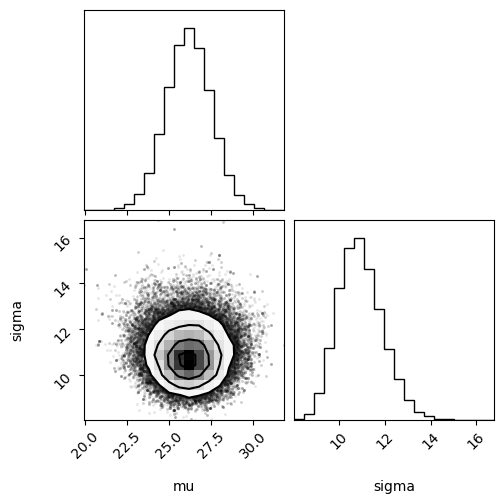

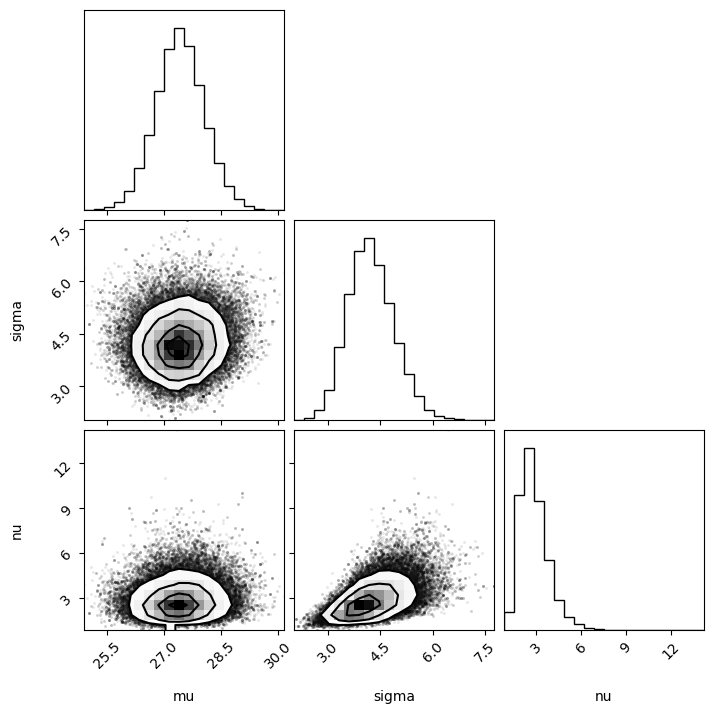

In [6]:
import corner 
fig = corner.corner(thetas_m1, labels=["mu", "sigma"],
                    figsize=(6.4, 6.4), dpi=200)
plt.savefig("./figures/lec9/newcomb-model1-posterior.png")
plt.show()

thetas_m2_copy = thetas_m2.copy()
thetas_m2_copy[:,2] = np.exp(thetas_m2[:,2])

fig = corner.corner(thetas_m2_copy, labels=["mu", "sigma", "nu"], 
                    figsize=(6.4, 6.4), dpi=200)
plt.savefig("./figures/lec9/newcomb-model2-posterior.png")
plt.show()

## Bayes factors

In [7]:
from scipy.optimize import minimize
from numdifftools import Hessian

def laplace_approximation(log_posterior, data, theta_init):
    neg_log_post = lambda theta: -log_posterior(theta, data)
    result = minimize(neg_log_post, x0=theta_init, method='BFGS')
    theta_map = result.x
    
    hess = Hessian(neg_log_post)(theta_map)
    Sigma = np.linalg.inv(hess)
    
    return theta_map, Sigma

def marginal_likelihood_laplace(log_posterior, log_prior, data, theta_init):
    theta_map, Sigma = laplace_approximation(log_posterior, data, theta_init)
    d = len(theta_map)
    
    log_likelihood_map = log_posterior(theta_map, data) - log_prior(theta_map)
    log_prior_map = log_prior(theta_map)
    
    log_evidence = (log_likelihood_map + 
                   log_prior_map + 
                   0.5 * d * np.log(2 * np.pi) + 
                   0.5 * np.linalg.slogdet(Sigma)[1])
    
    return log_evidence

log_evidence_m1 = marginal_likelihood_laplace(log_posterior_m1, log_prior_m1, light_speed, [26, 5])
log_evidence_m2 = marginal_likelihood_laplace(log_posterior_m2, log_prior_m2, light_speed, [26, 5, 3])

print("Log BF (m2/m1):", log_evidence_m2 - log_evidence_m1)

Log BF (m2/m1): 29.784604558406357


## K-Fold cross-validation

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
elpd_m1_list = []
elpd_m2_list = []

for train_index, test_index in kf.split(light_speed):
    # Posteriors on training set
    thetas_m1_cv = mcmc(log_posterior_m1, 2, light_speed[train_index], n_walkers=10, n_steps=25000)
    thetas_m2_cv = mcmc(log_posterior_m2, 3, light_speed[train_index], n_walkers=10, n_steps=25000)
    print(thetas_m1_cv.shape, thetas_m2_cv.shape)

    # Log posterior predictive on test set
    elpd_m1 = 0
    elpd_m2 = 0

    for theta in thetas_m1_cv:
        elpd_m1 += log_likelihood_m1(theta, light_speed[test_index])
    for theta in thetas_m2_cv:
        elpd_m2 += log_likelihood_m2(theta, light_speed[test_index])

    elpd_m1 /= thetas_m1_cv.shape[0]
    elpd_m2 /= thetas_m2_cv.shape[0]

    elpd_m1_list.append(elpd_m1)
    elpd_m2_list.append(elpd_m2)

mean_elpd_m1 = np.mean(elpd_m1_list)
mean_elpd_m2 = np.mean(elpd_m2_list)

100%|██████████| 2500/2500 [00:09<00:00, 257.96it/s]


(25000, 2) (25000, 3)


100%|██████████| 2500/2500 [00:09<00:00, 251.21it/s]


(25000, 2) (25000, 3)


100%|██████████| 2500/2500 [00:10<00:00, 248.68it/s]


(25000, 2) (25000, 3)


100%|██████████| 2500/2500 [00:09<00:00, 251.77it/s]


(25000, 2) (25000, 3)


100%|██████████| 2500/2500 [00:09<00:00, 252.81it/s]


(25000, 2) (25000, 3)


In [9]:
print("ELPD m1:", mean_elpd_m1)
print("ELPD m2:", mean_elpd_m2)

ELPD m1: -68.5134364616167
ELPD m2: -48.28900073597093
